In [52]:
VERSION = 5

In [55]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("data/train.csv") 
print("Train shape:", train.shape )
TRAIN_LN = len(train)
display( train.head(1) )

test = pd.read_csv("data/test.csv") 
test['price'] = 0
print("Test shape:", test.shape )
display( test.head(1) )

# train = pd.concat([train,test],axis=0,ignore_index=True)
# print("Combined shape:", train.shape )

Train shape: (188533, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200


Test shape: (125690, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,0


In [56]:
import re

def decode_engine(s:str):
    s = s.lower()
    # extract HP
    hpgroup = re.match(r'(\d+(\.\d+)?\s*)hp', s )
    engine_hp = float(hpgroup.group(1)) if hpgroup else 0.0
    # extract cc
    ccgroup = re.search(r'(\d+(\.\d+)?\s*)l', s )
    engine_cc = float(ccgroup.group(1)) if ccgroup else 0.0
    # extract cylinder cnt
    cylindergroup = re.search(r'(\d+(\.\d+)?\s*)cylinder', s )
    engine_cyl = int(cylindergroup.group(1)) if cylindergroup else 0
    # turbo
    turbogroup = re.search(r'turbo', s)
    turbo = 'Turbo' if turbogroup else 'Non-Turbo'
    # flex fuel
    flexgroup = re.search(r'flex fuel|flex', s)
    flex_fuel = 'Flex Fuel' if flexgroup else 'Non-Flex Fuel'
    # hybrid
    hybridgroup = re.search(r'hybrid', s)
    hybrid = 'Hybrid' if hybridgroup else 'Non-Hybrid'
    # electric
    electricgroup = re.search(r'electric', s)
    electric = 'Electric' if electricgroup else 'Non-Electric'

    return engine_hp, engine_cc, engine_cyl, turbo, flex_fuel, hybrid, electric


train[['engine_hp','engine_cc','engine_cyl','engine_turbo','engine_flexfuel','engine_hybrid','electric']] = train['engine'].apply(decode_engine).apply(pd.Series)
test[['engine_hp','engine_cc','engine_cyl','engine_turbo','engine_flexfuel','engine_hybrid','electric']] = test['engine'].apply(decode_engine).apply(pd.Series)

# train.drop(columns=['engine'], inplace=True)
# test.drop(columns=['engine'], inplace=True)



In [57]:
CATS = [c for c in train.columns if not c in ["id","price"] ]
NUMS = ['milage', 'engine_hp', 'engine_cc', 'engine_cyl']
CATS = [c for c in CATS if not c in NUMS]
print("Categorical features:", CATS )
print("Numerical features:", NUMS)

Categorical features: ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'engine_turbo', 'engine_flexfuel', 'engine_hybrid', 'electric']
Numerical features: ['milage', 'engine_hp', 'engine_cc', 'engine_cyl']


# Target variable analysis

Text(0, 0.5, 'Density')

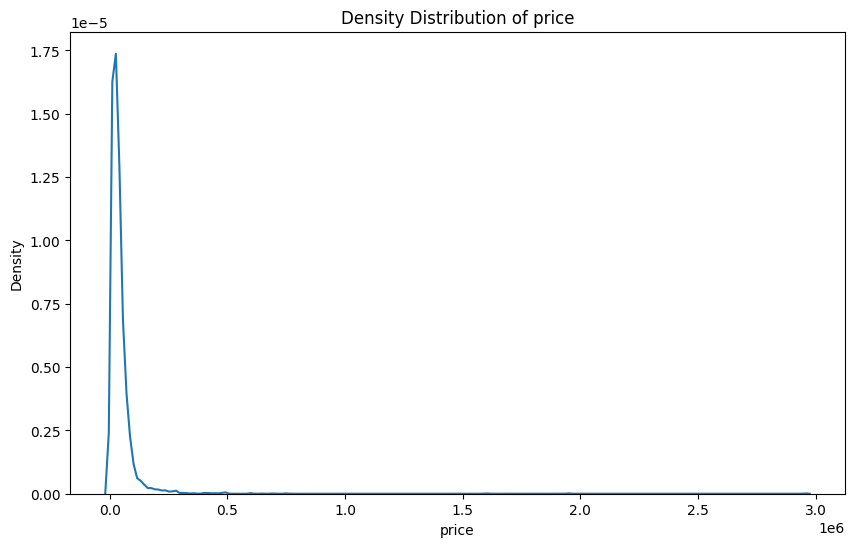

In [25]:
# visualize density distribution of price, the target variable
plt.figure(figsize=(10, 6))
sns.kdeplot(train['price'].values, label='Density of price')
plt.title('Density Distribution of price')
plt.xlabel('price')
plt.ylabel('Density')

price is an extremely right skewed distribution, like a long tail distribution. 
To transform the price variable to make it more normal, we can consider the following approaches:

1. Log transformation: This is often effective for right-skewed distributions. It can help compress the long tail and make the distribution more symmetric.
   We could use: `np.log1p(train['price'])` (log1p is used to handle zero values)

2. Square root transformation: This is less drastic than log transformation and can be useful for moderately skewed distributions.
   We could use: `np.sqrt(train['price'])`

3. Box-Cox transformation: This is a family of power transformations that includes log transformation as a special case. It can be more flexible than log transformation.
   We could use: `scipy.stats.boxcox(train['price'])`

4. Yeo-Johnson transformation: Similar to Box-Cox, but can handle negative values as well.
   We could use: `scipy.stats.yeojohnson(train['price'])`

After applying any of these transformations, we should visualize the transformed distribution to see if it's more normal. We may need to experiment with different transformations to find the one that works best for our data.


Text(0.5, 0, 'price')

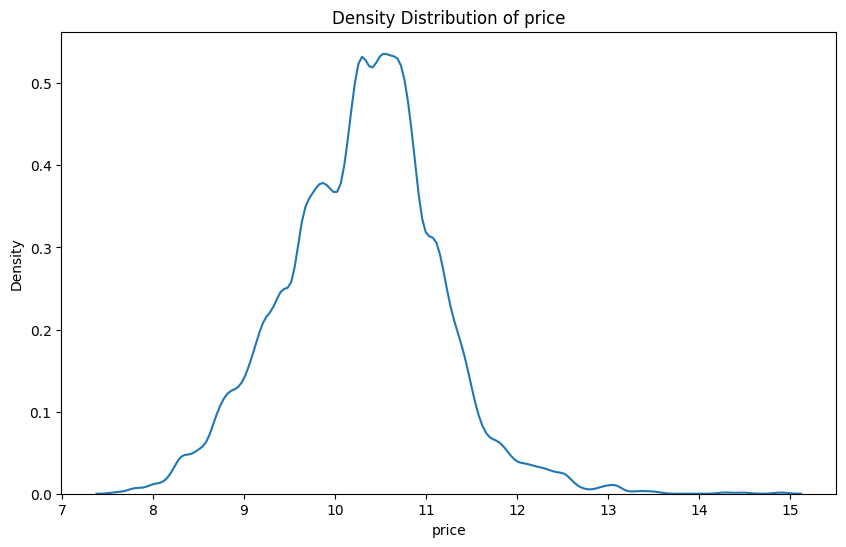

In [26]:
# Let's try the log transformation first
transformed_price = np.log1p(train['price'].values)

# visualize density distribution of price
plt.figure(figsize=(10, 6))
sns.kdeplot(transformed_price, label='Density of transformed price')
plt.title('Density Distribution of price')
plt.xlabel('price')

After the above transformation we have an almost normal distribution. but slightly higher density at the lower end, but I think this is acceptable level of skewness and hopefully our learn can handle this.

In [28]:
train['log_price'] = np.log1p(train['price'].values)
train.head()

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,engine_hp,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,log_price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.343078
1,1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.517193
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8,Non-Turbo,Flex Fuel,Non-Hybrid,Non-Electric,9.539716
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,10.714440
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,11.487618


# Target variable trasformation

In [58]:
train['price_transformed'] = np.log1p(train['price'].values)
display(train.head(1))

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,clean_title,price,engine_hp,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,price_transformed
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,Yes,4200,172.0,1.6,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.343078


# Numerical Features Analysis - 1

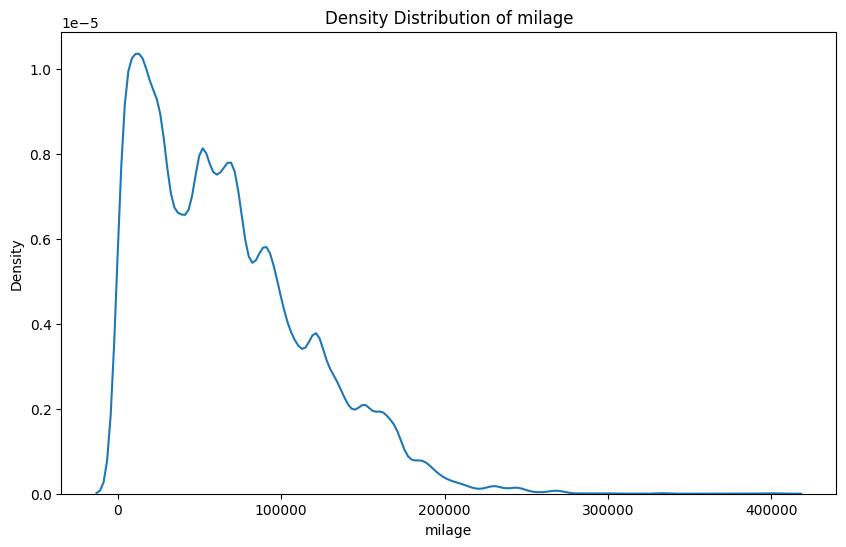

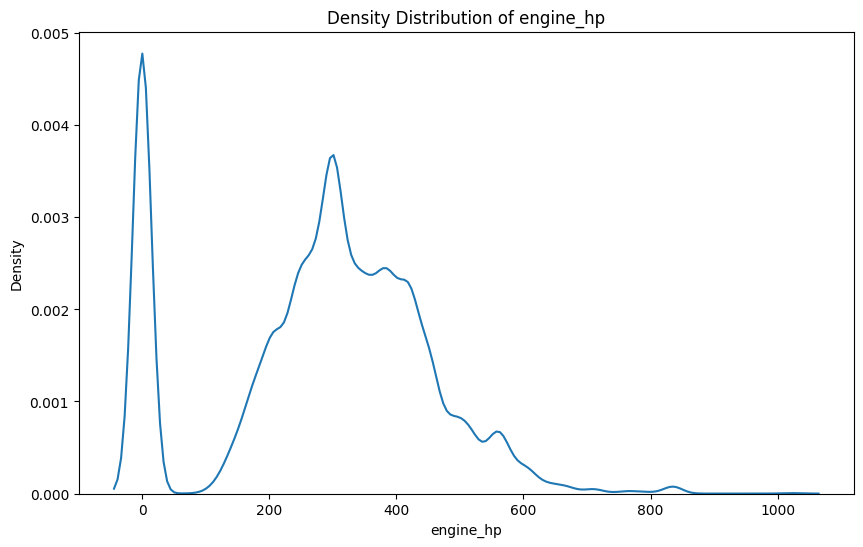

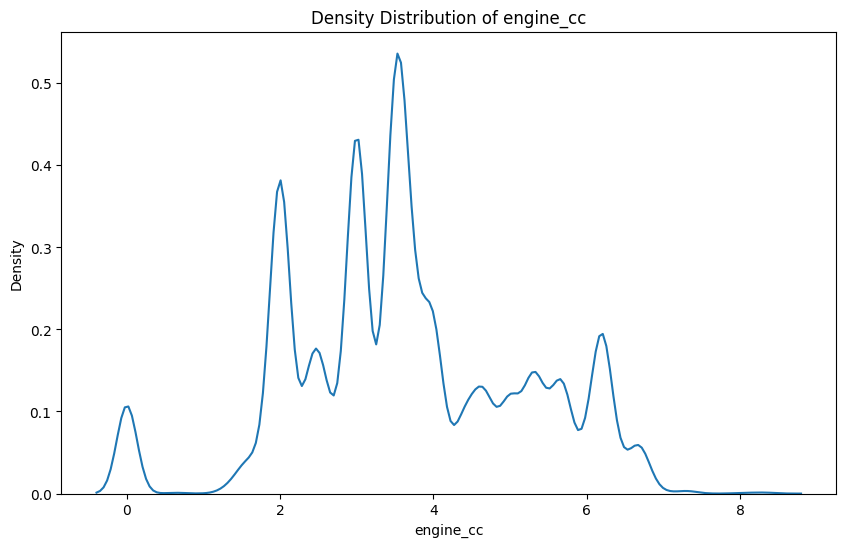

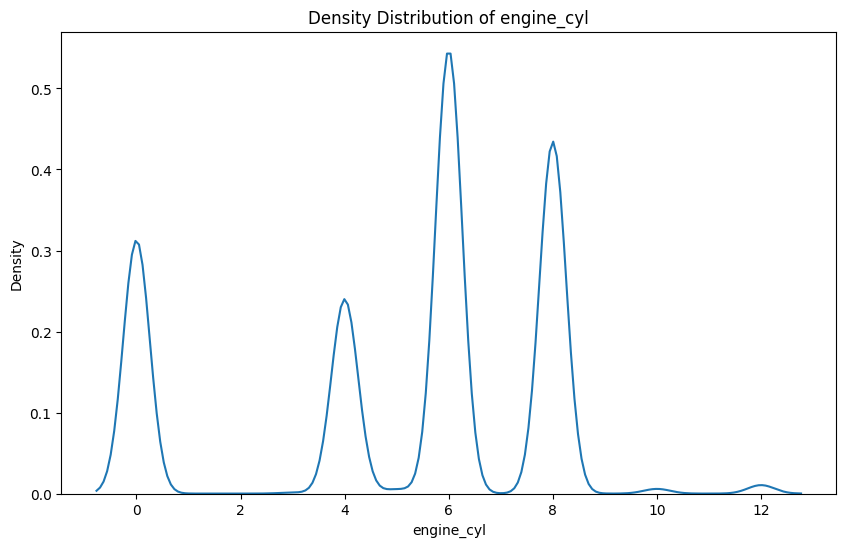

In [29]:
# visualize density distribution of numerical features
import seaborn as sns
import matplotlib.pyplot as plt

for feature in NUMS:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train[feature], label=f'Density of {feature}')
    plt.title(f'Density Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

From the above visualisations my thoughts are:
- milage is skewed to the right, with a long tail towards the higher end. Kind of like a long tail distribution.
- engine_hp is almost a normal, except for very high values at 0, which is the default value we put in for missing values.
- engine_cc is a multi-peak distribution with mode just under 4, maximum being upwards of 8. There is a peak at 0, which is the default value we put in for missing values.
- engine_cyl with multiple peaks at 0, 4, 6, 8, 10 and 12. 0s are again the default values we put in for missing values.

# engine_cyl
`engine_cyl` I think makes a lot of sense to be a categorical feature, with 0 being the default value for missing data, and the other values being the actual number of cylinders in the engine. We can try leaving this as is or try replacing 0s with something else, we will look at this imputation later, first let's just try giving zero as one of the categories.

In [59]:
# remove engine_cyl from the numerical features and add it to the categorical features
CATS.append('engine_cyl')
NUMS = [c for c in NUMS if c != 'engine_cyl']

# Numerical Features Analysis

## milage
`milage` is skewed to the right, with a long tail towards the higher end. 
Let us try to make it normal by taking the log of it.


Text(0, 0.5, 'Density')

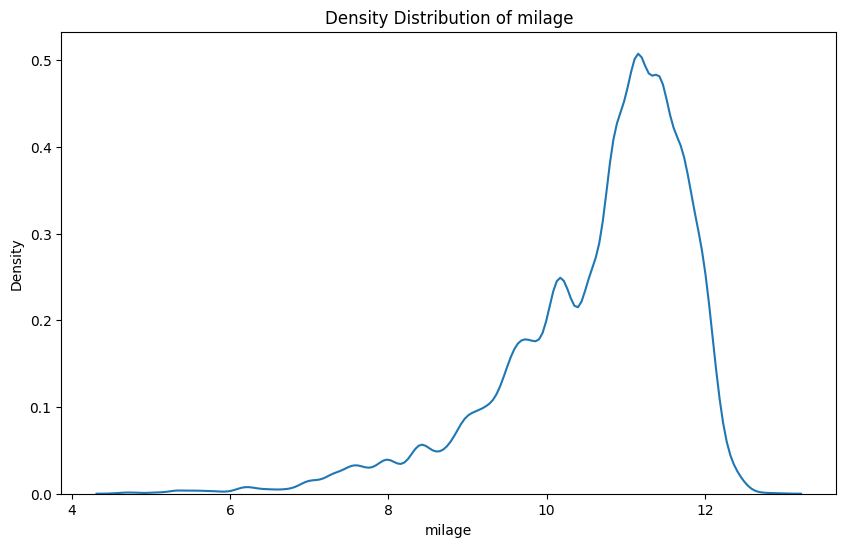

In [32]:
# log transformation of milage
plt.figure(figsize=(10, 6))
sns.kdeplot(np.log1p(train['milage'].values), label='Density of log(milage)')
plt.title('Density Distribution of milage')
plt.xlabel('milage')
plt.ylabel('Density')

damn son the above log transformed milage is also skewed but this time to the left. WTF!

We want to find a transformation for milage that makes it more normal. So, let us try
using the Box-Cox or Yeo-Johnson transformation, which can help normalize skewed data.
If those don't work well, we can also try the quantile transformation method.

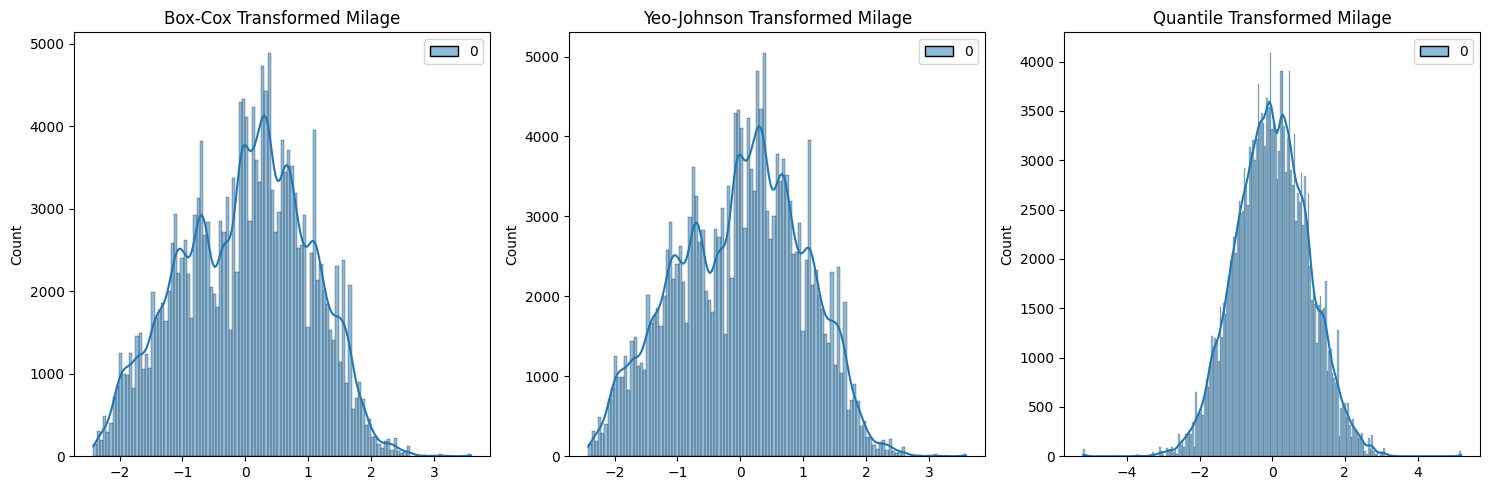

In [33]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Try Box-Cox transformation
bc_transformer = PowerTransformer(method='box-cox')
milage_bc = bc_transformer.fit_transform(train[['milage']])

# Try Yeo-Johnson transformation
yj_transformer = PowerTransformer(method='yeo-johnson')
milage_yj = yj_transformer.fit_transform(train[['milage']])

# Try Quantile transformation
qt_transformer = QuantileTransformer(output_distribution='normal')
milage_qt = qt_transformer.fit_transform(train[['milage']])

# Plot the results to compare which transformation works best
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(milage_bc, kde=True)
plt.title('Box-Cox Transformed Milage')
plt.subplot(132)
sns.histplot(milage_yj, kde=True)
plt.title('Yeo-Johnson Transformed Milage')
plt.subplot(133)
sns.histplot(milage_qt, kde=True)
plt.title('Quantile Transformed Milage')
plt.tight_layout()
plt.show()

wow, all the transformations are very good normal distributions, but the quantile transformation is WOW like literally text book normal distribution. So let's use the quantile transformed milage to train our model.

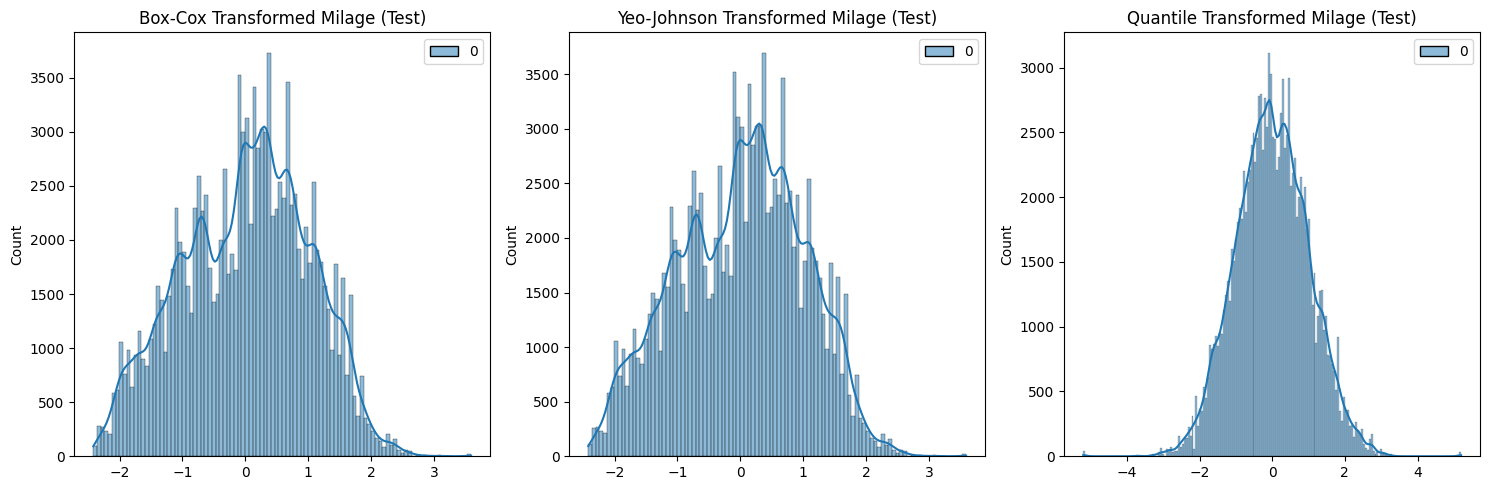

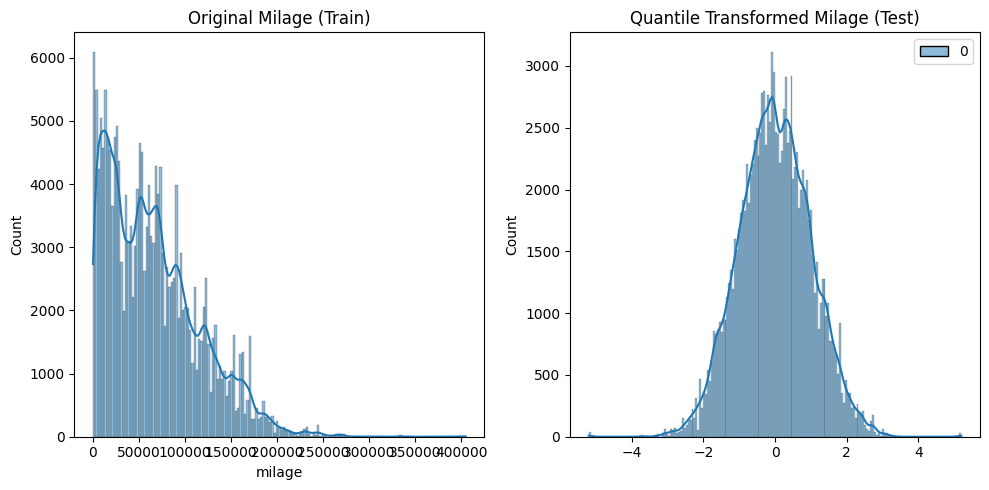

In [34]:
# Let's look at distributions of all three transformations on the test set too, without storing them in the dataframe just yet.
# Apply the transformations to the test set
milage_bc_test = bc_transformer.transform(test[['milage']])
milage_yj_test = yj_transformer.transform(test[['milage']])
milage_qt_test = qt_transformer.transform(test[['milage']])

# Plot the results for the test set
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(milage_bc_test, kde=True)
plt.title('Box-Cox Transformed Milage (Test)')
plt.subplot(132)
sns.histplot(milage_yj_test, kde=True)
plt.title('Yeo-Johnson Transformed Milage (Test)')
plt.subplot(133)
sns.histplot(milage_qt_test, kde=True)
plt.title('Quantile Transformed Milage (Test)')
plt.tight_layout()
plt.show()

# Compare the distributions of train and test sets for the quantile transformation
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.histplot(train['milage'], kde=True)
plt.title('Original Milage (Train)')
plt.subplot(122)
sns.histplot(milage_qt_test, kde=True)
plt.title('Quantile Transformed Milage (Test)')
plt.tight_layout()
plt.show()


alright let us stick with the quantile transformed milage for now.

In [35]:
train['milage_qt'] = milage_qt
test['milage_qt'] = milage_qt_test
display(train.head(1))

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,...,price,engine_hp,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,log_price,milage_qt
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,...,4200,172.0,1.6,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.343078,2.439669


## engine_hp
`engine_hp` is almost a normal distribution, except for very high values at 0, which are the default values we put in for missing data. So, let us just impute the 0 values with the mean of the non-zero values

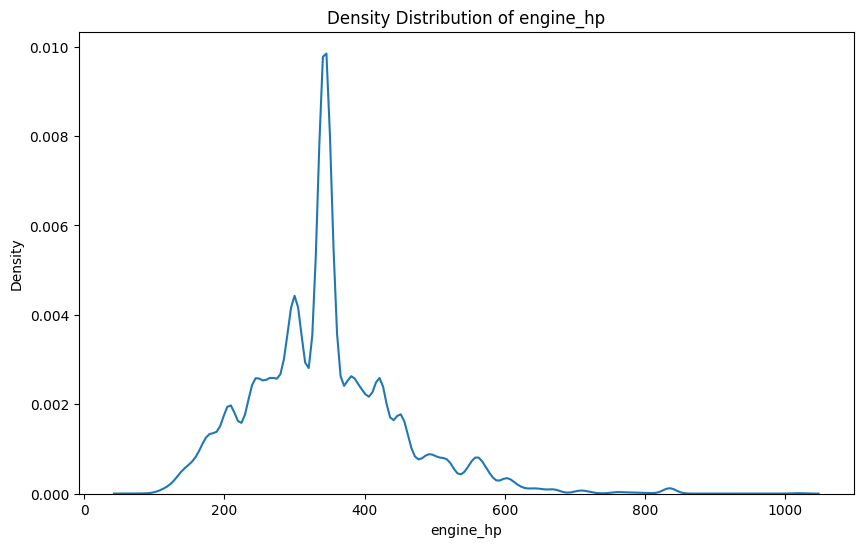

In [36]:
# let us visualize the transformed engine_hp distribution with mean imputation, without storing it in the dataframe just yet.
engine_hp_mean = train[train['engine_hp'] != 0]['engine_hp'].mean()
engine_hp_transformed = np.where(train['engine_hp'] == 0, engine_hp_mean, train['engine_hp'])
plt.figure(figsize=(10, 6))
sns.kdeplot(engine_hp_transformed, label='Density of engine_hp')
plt.title('Density Distribution of engine_hp')
plt.xlabel('engine_hp')
plt.ylabel('Density')
plt.show()

well that is sure as hell not a normal distribution, it is right skewed, with a long tail towards the higher end and a HUGE peak at the mean value because of all the imputation. For starters, I do not think mean imputation is a good idea here, but the imputation should be with a random value from the distribution closest to non-zero values' distribution.

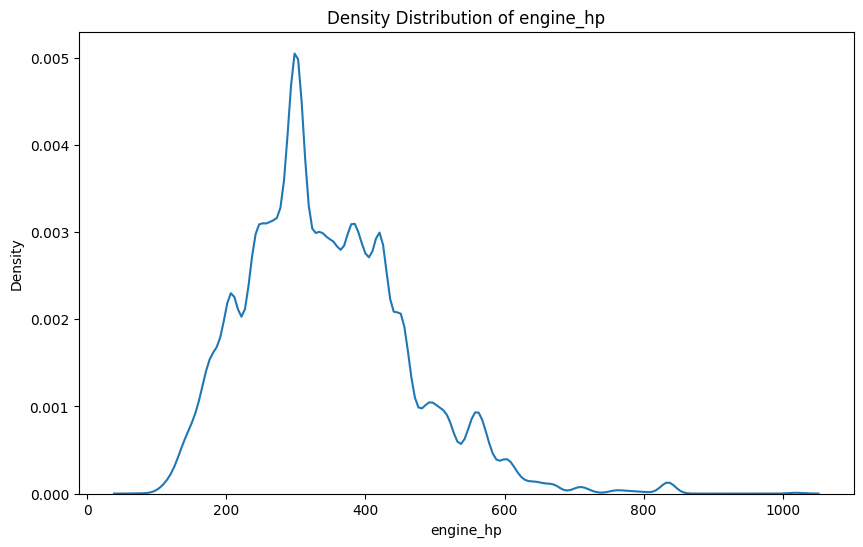

In [37]:
# visualize non-zero values of engine_hp distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(train[train['engine_hp'] != 0]['engine_hp'], label='Density of engine_hp')
plt.title('Density Distribution of engine_hp')
plt.xlabel('engine_hp')
plt.ylabel('Density')
plt.show()

In [38]:
train[train['engine_hp'] != 0]['engine_hp'].value_counts()

engine_hp
300.0    5416
355.0    4433
420.0    4020
240.0    3634
400.0    3518
         ... 
322.0       2
70.0        1
111.0       1
78.0        1
313.0       1
Name: count, Length: 348, dtype: int64

Let us look at the log-transformation engine_hp distribution

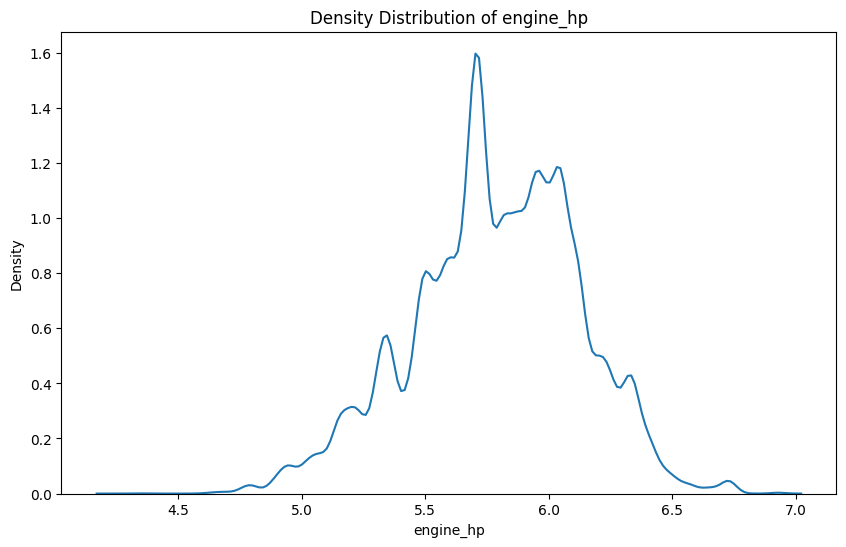

In [40]:
# log transformation of engine_hp
plt.figure(figsize=(10, 6))
sns.kdeplot(np.log1p(train[train['engine_hp'] != 0]['engine_hp'].values), label='Density of engine_hp')
plt.title('Density Distribution of engine_hp')
plt.xlabel('engine_hp')
plt.ylabel('Density')
plt.show()

Not really a good normal distribution, but that is the type of data we are dealing with, maybe kinda have to suck it up and live with it. let's look at the distribution where we replace non-zero values with the log transformed values and replace 0s with the mean of the log transformed values of non-zero values.

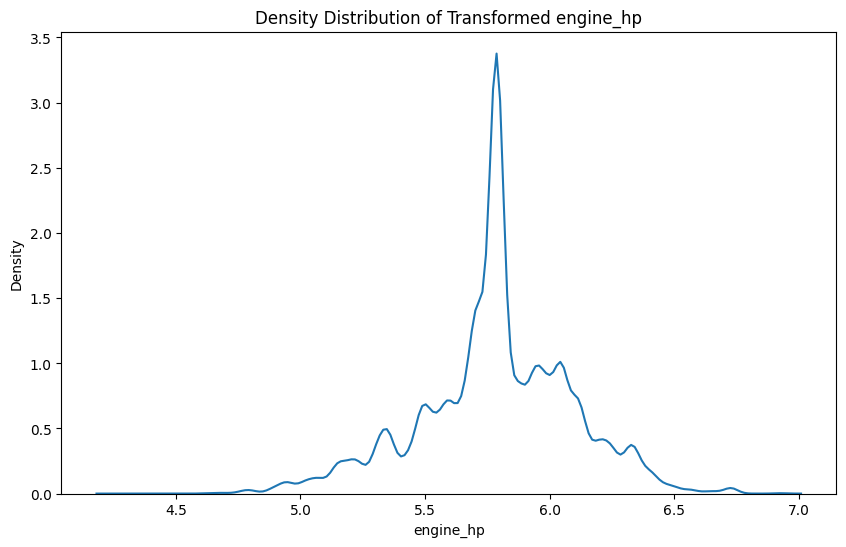

In [41]:
# log transformation of non-zero engine_hp values
log_engine_hp = np.log1p(train[train['engine_hp'] != 0]['engine_hp'].values)
mean_log_engine_hp = log_engine_hp.mean()

# replace 0s with the mean of the log transformed values
transformed_engine_hp = train['engine_hp'].apply(lambda x: mean_log_engine_hp if x == 0 else np.log1p(x))

plt.figure(figsize=(10, 6))
sns.kdeplot(transformed_engine_hp, label='Density of transformed engine_hp')
plt.title('Density Distribution of Transformed engine_hp')
plt.xlabel('engine_hp')
plt.ylabel('Density')
plt.show()


HAHAHA! This looks like a normal distribution with a rhino horn. LMAOOO!! What a joke!

We want to find a transformation for engine_hp that makes it more normal. So, let us try
using the Box-Cox or Yeo-Johnson transformation, which can help normalize skewed data.
If those don't work well, we can also try the quantile transformation method.

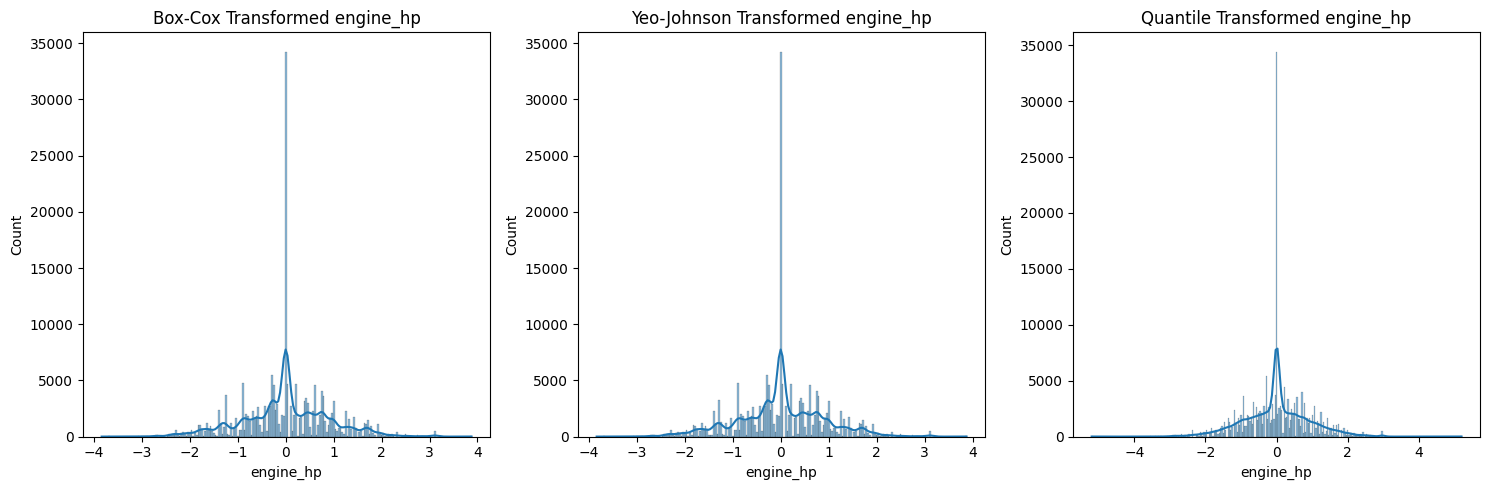

In [46]:
import warnings
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Filter out zero values because they are just place holders for missing data.
non_zero_engine_hp = train[train['engine_hp'] != 0][['engine_hp']]

def apply_transformation(transformer, data, mean_value):
    # Apply the transformation to each value in the data. If the value is 0, replace it with the mean value of the transformed data.
    # Otherwise, apply the transformation to the value.
    return data.apply(lambda x: mean_value if x == 0 else transformer.transform([[x]])[0][0])

def plot_transformed_data(data, title, subplot_position):
    plt.subplot(subplot_position)
    sns.histplot(data, kde=True)
    plt.title(title)

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Box-Cox transformation
bc_transformer_engine_hp = PowerTransformer(method='box-cox')
engine_hp_bc = bc_transformer_engine_hp.fit_transform(non_zero_engine_hp)
mean_engine_hp_bc = engine_hp_bc.mean()
transformed_engine_hp_bc = apply_transformation(bc_transformer_engine_hp, train['engine_hp'], mean_engine_hp_bc)

# Yeo-Johnson transformation
yj_transformer_engine_hp = PowerTransformer(method='yeo-johnson')
engine_hp_yj = yj_transformer_engine_hp.fit_transform(non_zero_engine_hp)
mean_engine_hp_yj = engine_hp_yj.mean()
transformed_engine_hp_yj = apply_transformation(yj_transformer_engine_hp, train['engine_hp'], mean_engine_hp_yj)

# Quantile transformation
qt_transformer_engine_hp = QuantileTransformer(output_distribution='normal')
engine_hp_qt = qt_transformer_engine_hp.fit_transform(non_zero_engine_hp)
mean_engine_hp_qt = engine_hp_qt.mean()
transformed_engine_hp_qt = apply_transformation(qt_transformer_engine_hp, train['engine_hp'], mean_engine_hp_qt)

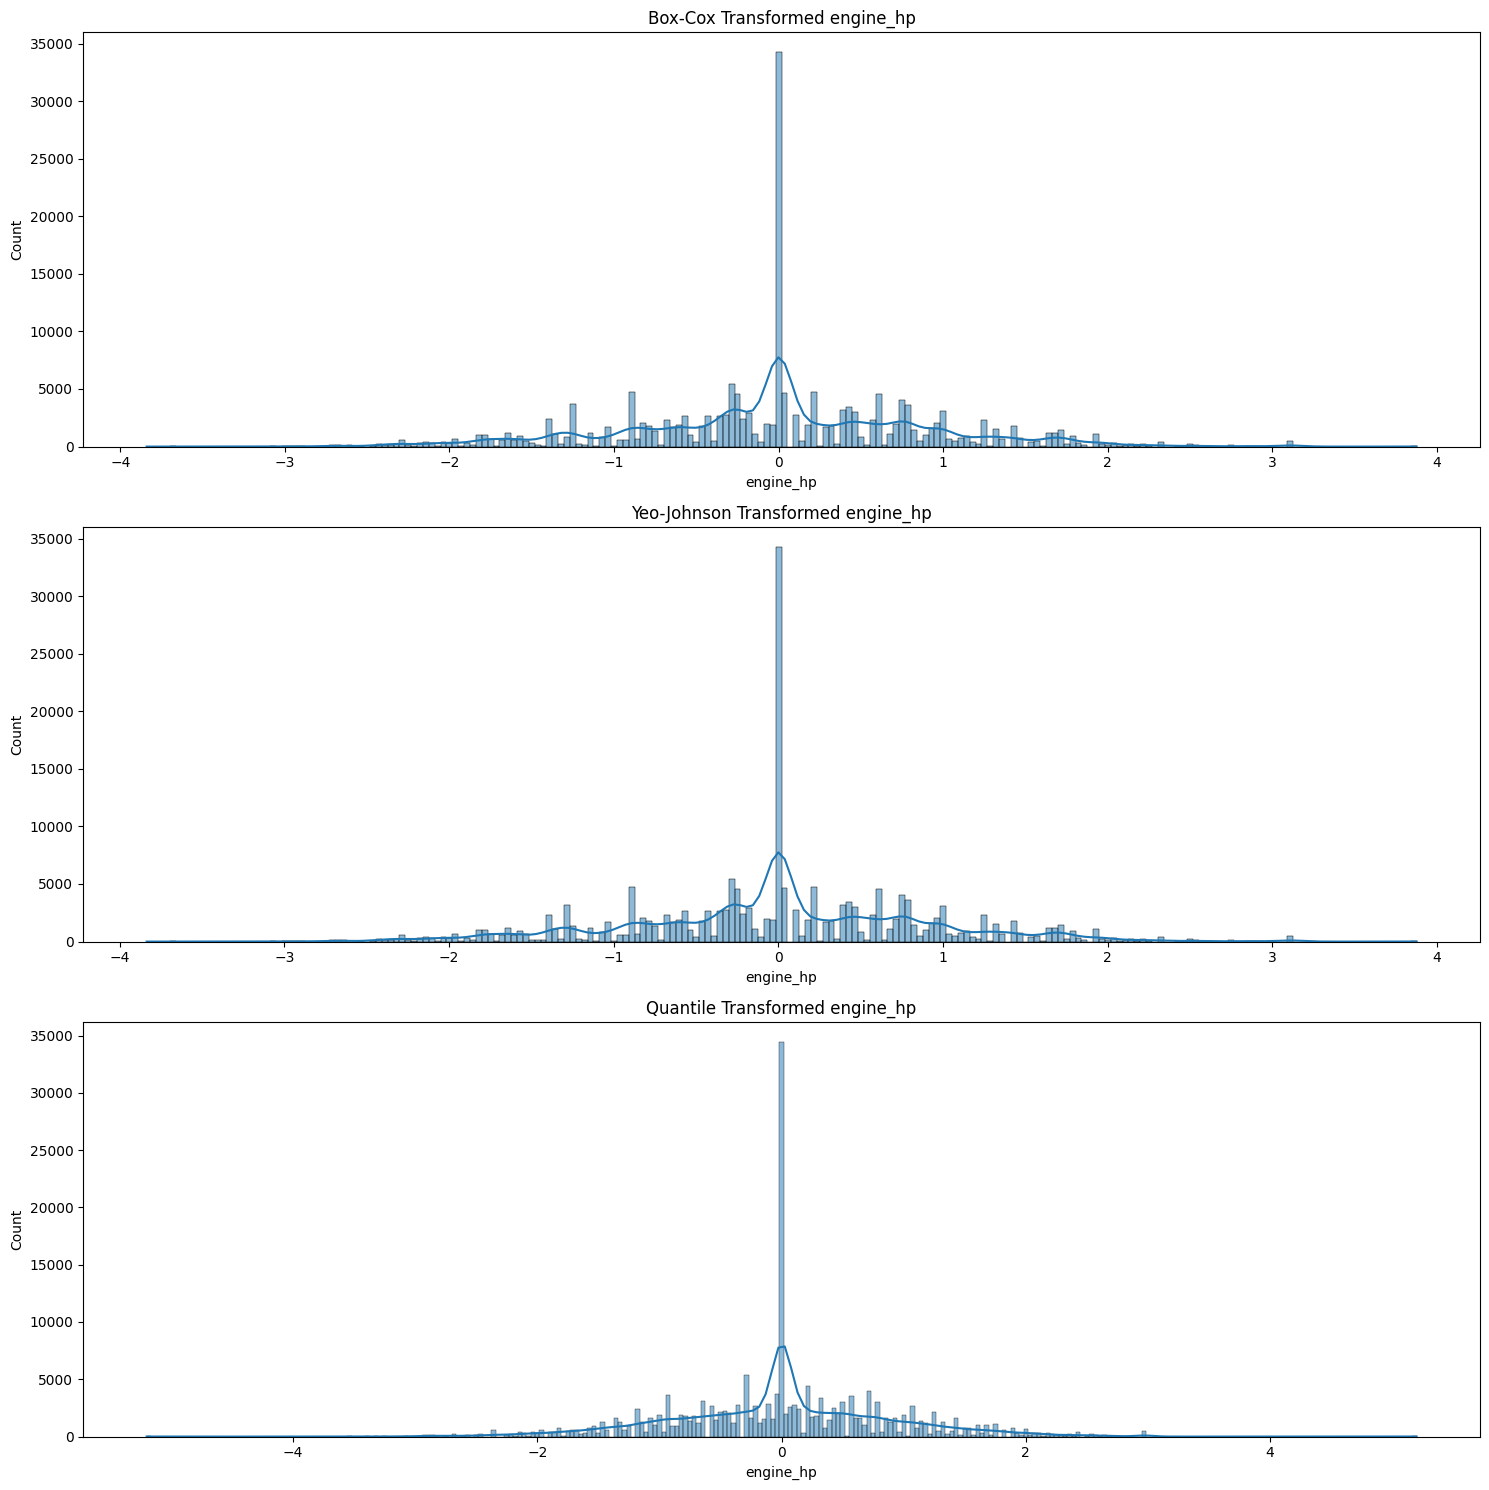

In [47]:
# Plot the results to compare which transformation works best
plt.figure(figsize=(15, 15))

plt.subplot(311)
plot_transformed_data(transformed_engine_hp_bc, 'Box-Cox Transformed engine_hp', 311)

plt.subplot(312)
plot_transformed_data(transformed_engine_hp_yj, 'Yeo-Johnson Transformed engine_hp', 312)

plt.subplot(313)
plot_transformed_data(transformed_engine_hp_qt, 'Quantile Transformed engine_hp', 313)

plt.tight_layout()
plt.show()

All looks good, I want to use Yeo-Johnson transformation for engine_hp because here the distribution we are getting looks closer to a normal distribution but also not as smooth as quantile transformation. Just feeling maybe we are losing some information with quantile transformation. Do not have a solid reason just a feeling. But going with it. Yeo-Johnson transformation it is!

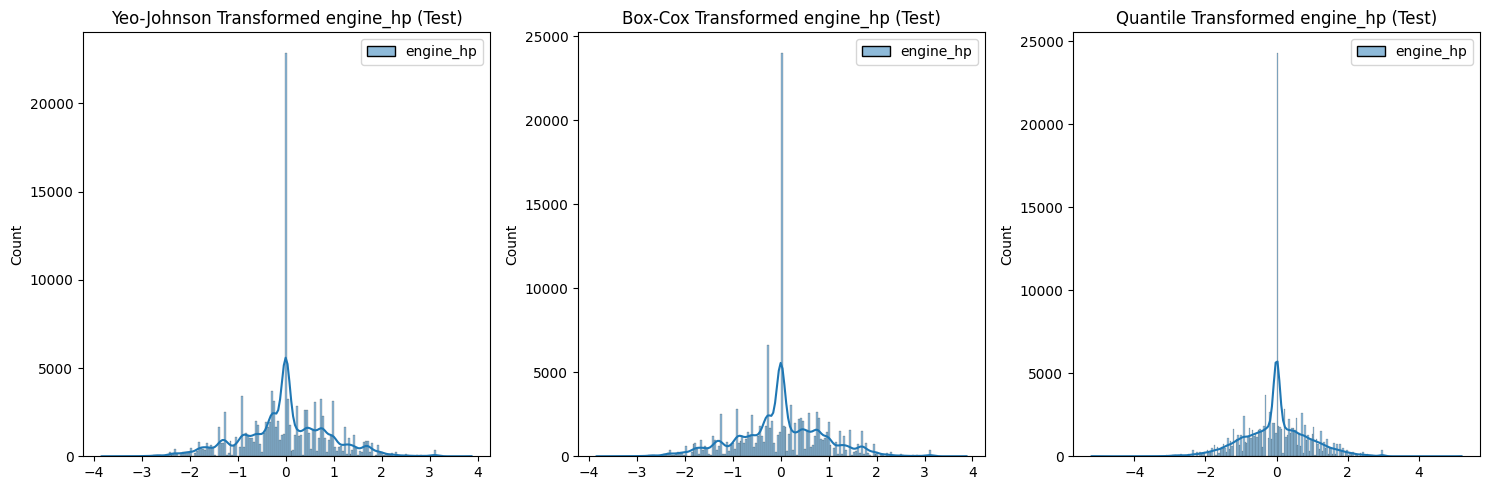

In [50]:
# Let's look at distributions of all three transformations on the test set too, without storing them in the dataframe just yet.
# Apply the transformations to the test set
# Apply Yeo-Johnson transformation on non-zero values and mean imputation for zero values
transformed_engine_hp_yj_test = test[['engine_hp']].copy()
non_zero_mask = transformed_engine_hp_yj_test['engine_hp'] != 0
transformed_engine_hp_yj_test.loc[non_zero_mask, 'engine_hp'] = yj_transformer_engine_hp.transform(transformed_engine_hp_yj_test.loc[non_zero_mask, ['engine_hp']]).flatten()
transformed_engine_hp_yj_test.loc[~non_zero_mask, 'engine_hp'] = mean_engine_hp_yj

# Apply Box-Cox transformation on non-zero values and mean imputation for zero values
transformed_engine_hp_bc_test = test[['engine_hp']].copy()
non_zero_mask = transformed_engine_hp_bc_test['engine_hp'] != 0
transformed_engine_hp_bc_test.loc[non_zero_mask, 'engine_hp'] = bc_transformer_engine_hp.transform(transformed_engine_hp_bc_test.loc[non_zero_mask, ['engine_hp']]).flatten()
transformed_engine_hp_bc_test.loc[~non_zero_mask, 'engine_hp'] = mean_engine_hp_bc

# Apply Quantile transformation on non-zero values and mean imputation for zero values
transformed_engine_hp_qt_test = test[['engine_hp']].copy()
non_zero_mask = transformed_engine_hp_qt_test['engine_hp'] != 0
transformed_engine_hp_qt_test.loc[non_zero_mask, 'engine_hp'] = qt_transformer_engine_hp.transform(transformed_engine_hp_qt_test.loc[non_zero_mask, ['engine_hp']]).flatten()
transformed_engine_hp_qt_test.loc[~non_zero_mask, 'engine_hp'] = mean_engine_hp_qt

# Plot the results for the test set
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(transformed_engine_hp_yj_test, kde=True)
plt.title('Yeo-Johnson Transformed engine_hp (Test)')
plt.subplot(132)
sns.histplot(transformed_engine_hp_bc_test, kde=True)
plt.title('Box-Cox Transformed engine_hp (Test)')
plt.subplot(133)
sns.histplot(transformed_engine_hp_qt_test, kde=True)
plt.title('Quantile Transformed engine_hp (Test)')
plt.tight_layout()
plt.show()

In [54]:
train['engine_hp_yj'] = transformed_engine_hp_yj
test['engine_hp_yj'] = transformed_engine_hp_yj_test
display(train.head(1))

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,...,engine_hp,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,log_price,milage_qt,engine_hp_yj
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,...,172.0,1.6,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.343078,2.439669,-1.787182


## engine_cc
`engine_cc` is a multi-peak distribution with mode just under 4, maximum being upwards of 8. There is a peak at 0, which is the default value we put in for missing values.

First let us try to do mean imputation of 0 values with the mean of the non-zero values.

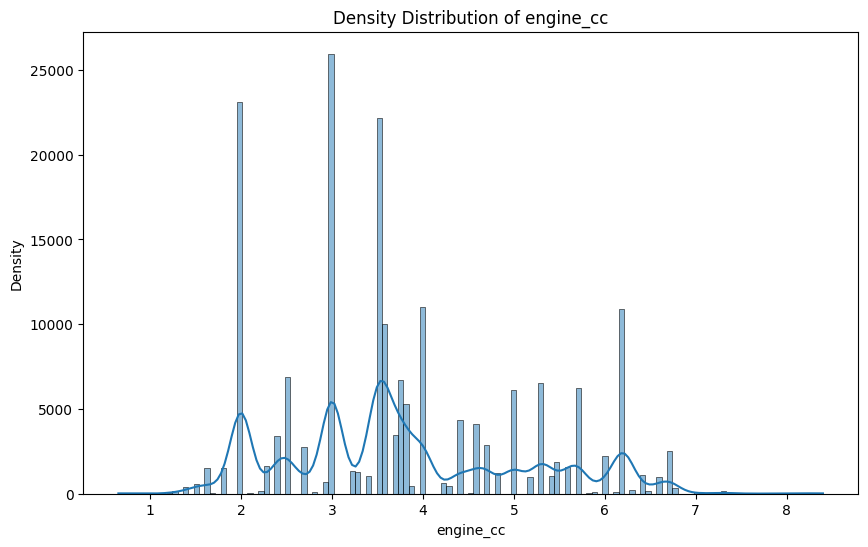

In [55]:
# mean imputation of 0 values with the mean of the non-zero values
engine_cc_mean = train[train['engine_cc'] != 0]['engine_cc'].mean()
transformed_engine_cc_train = train['engine_cc'].apply(lambda x: engine_cc_mean if x == 0 else x)
transformed_engine_cc_test = test['engine_cc'].apply(lambda x: engine_cc_mean if x == 0 else x)

# visualize the distribution of engine_cc
plt.figure(figsize=(10, 6))
sns.histplot(transformed_engine_cc_train, kde=True)
plt.title('Density Distribution of engine_cc')
plt.xlabel('engine_cc')
plt.ylabel('Density')
plt.show()

we have multiple peaks in the distribution, let us try binning the data and look if that helps in making it more normal.

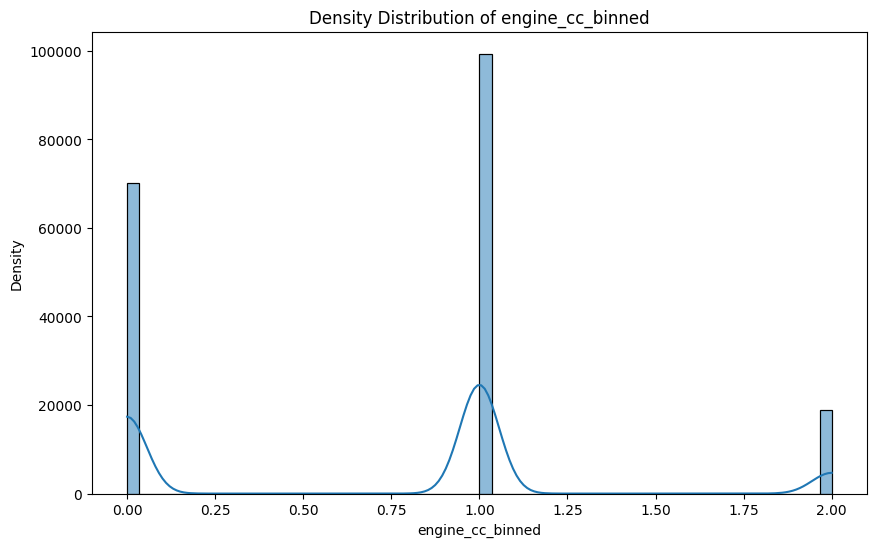

In [60]:
# binning the data
BINS = 3
engine_cc_binned_train = pd.cut(transformed_engine_cc_train, bins=BINS, labels=False)

# visualize the distribution of engine_cc_binned
plt.figure(figsize=(10, 6))
sns.histplot(engine_cc_binned_train, kde=True)
plt.title('Density Distribution of engine_cc_binned')
plt.xlabel('engine_cc_binned')
plt.ylabel('Density')
plt.show()

I did not like this binned distribution, it is not smooth and I feel like we are losing some information by binning it. We are just doing mean imputation and sending it to the model to learn better.

Text(0.5, 1.0, 'Density Distribution of engine_cc_test')

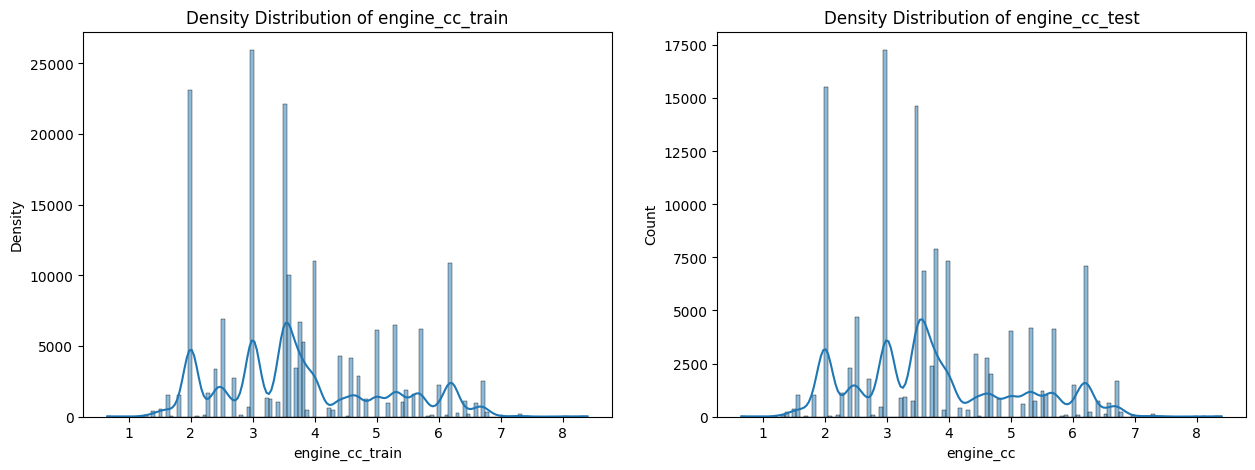

In [61]:
# let's visualize at data distribution after mean imputation data is in variables - transformed_engine_cc_train and transformed_engine_cc_test
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(transformed_engine_cc_train, kde=True)
plt.title('Density Distribution of engine_cc_train')
plt.xlabel('engine_cc_train')
plt.ylabel('Density')
plt.subplot(122)
sns.histplot(transformed_engine_cc_test, kde=True)
plt.title('Density Distribution of engine_cc_test')

Giving up after this, because I'm getting lazy about bringing this to a proper normal like we did with the other variables.

In [62]:
train['engine_cc_mean_imputed'] = transformed_engine_cc_train
test['engine_cc_mean_imputed'] = transformed_engine_cc_test
display(train.head(1))

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,...,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,log_price,milage_qt,engine_hp_yj,engine_cc_mean_imputed
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,...,1.6,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.343078,2.439669,-1.787182,1.6


## Standardization

Our final numerical features are `milage_qt`, `engine_hp_yj`, `engine_cc_mean_imputed` and the new target is `log_price`

In [63]:
NUMS = ['milage_qt', 'engine_hp_yj', 'engine_cc_mean_imputed']
TARGET = 'log_price'
print(CATS)

['brand', 'model', 'model_year', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'engine_turbo', 'engine_flexfuel', 'engine_hybrid', 'electric', 'engine_cyl']


STANDARDIZING NUMERICAL FEATURES
milage_qt, new_mean=0.00, new_std=1.00
engine_hp_yj, new_mean=-0.00, new_std=1.00
engine_cc_mean_imputed, new_mean=0.00, new_std=1.00


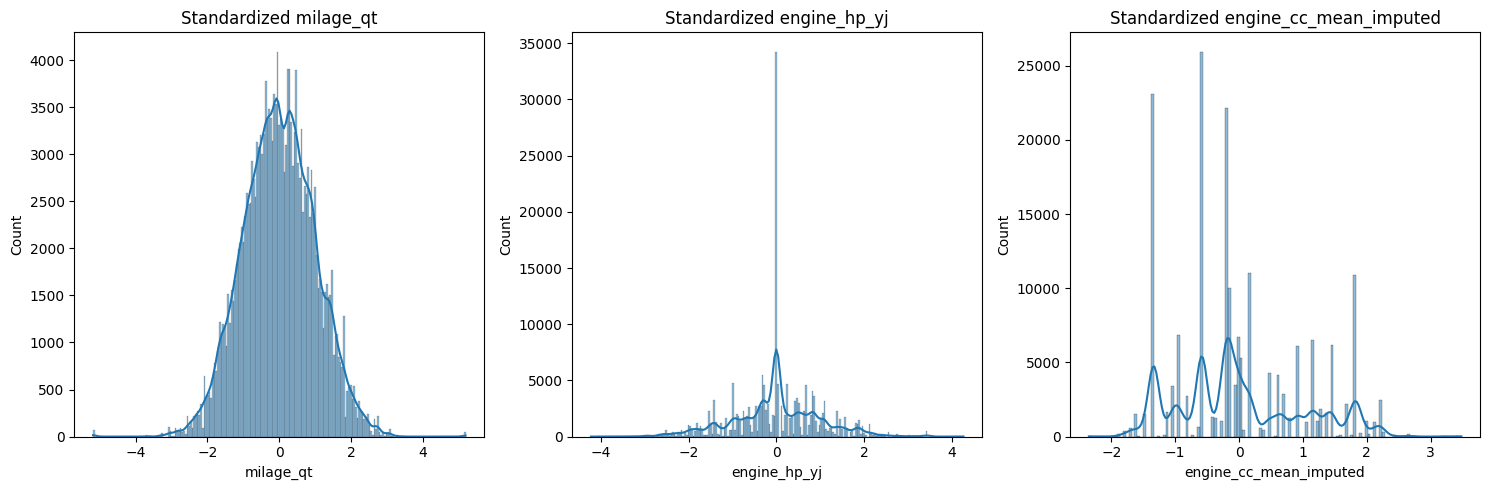

In [64]:
print("STANDARDIZING NUMERICAL FEATURES")
num_features = len(NUMS)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(15, 5 * num_rows))

for i, c in enumerate(NUMS):
    m = train[c].mean()
    s = train[c].std()
    train[c] = (train[c]-m)/s
    train[c] = train[c].fillna(m)
    print(f"{c}, new_mean={train[c].mean():.2f}, new_std={train[c].std():.2f}")
    
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(train[c], kde=True)
    plt.title(f'Standardized {c}')

plt.tight_layout()
plt.show()

## Analysis of usefulness of features
We will be looking at three metrics:
- Pearson correlation coefficient: Measures the linear relationship between each feature and the target variable.
- Spearman correlation coefficient: Measures the monotonic relationship AKA check if the relationship is increasing or decreasing monotonically between each feature and the target variable, useful to judge the relationship when we cannot assume linearity
- [Mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)

**How to interpret the results**:
- For pearson and spearman correlation we will be using the absolute values of the correlation coefficients, higher the value more useful the feature is.
- For mutual information, higher the value more useful the feature is.

In [72]:
# pearson correlation
correlation_matrix = train[NUMS + [TARGET]].corr()
print(correlation_matrix[TARGET].sort_values(ascending=False))

log_price                 1.000000
engine_hp_yj              0.498058
engine_cc_mean_imputed    0.153771
milage_qt                -0.694743
Name: log_price, dtype: float64


In [73]:
# spearman correlation
correlation_matrix = train[NUMS + [TARGET]].corr(method='spearman')
print(correlation_matrix[TARGET].sort_values(ascending=False))

log_price                 1.000000
engine_hp_yj              0.525693
engine_cc_mean_imputed    0.167172
milage_qt                -0.742709
Name: log_price, dtype: float64


In [74]:
# mutual information
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(train[NUMS], train[TARGET])
mi_scores = pd.Series(mi_scores, name="MI Scores", index=NUMS)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

milage_qt                 0.657884
engine_hp_yj              0.533069
engine_cc_mean_imputed    0.175352
Name: MI Scores, dtype: float64


# Numerical Feature transformations

In [60]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Milage
milage_transformer = QuantileTransformer(output_distribution='normal').fit(train['milage'].values.reshape(-1, 1)) # reshape is required for the fit method, because QuantileTransformer expects a 2D array
train['milage_transformed'] = milage_transformer.transform(train['milage'].values.reshape(-1, 1))
test['milage_transformed'] = milage_transformer.transform(test['milage'].values.reshape(-1, 1))

# Engine HP
engine_hp_transformer = PowerTransformer(method='yeo-johnson').fit(train['engine_hp'].values.reshape(-1, 1)) # reshape is required for the fit method, because PowerTransformer expects a 2D array
train['engine_hp_transformed'] = engine_hp_transformer.transform(train['engine_hp'].values.reshape(-1, 1))
test['engine_hp_transformed'] = engine_hp_transformer.transform(test['engine_hp'].values.reshape(-1, 1))

# Engine CC
def engine_cc_transformer(train, test):
    """
    We are just doing mean imputation here, because we want to keep the data as it is, to see if the model can learn the pattern from the data.
    """
    engine_cc_mean = train[train['engine_cc'] != 0]['engine_cc'].mean()
    transformed_engine_cc_train = train['engine_cc'].apply(lambda x: engine_cc_mean if x == 0 else x)
    transformed_engine_cc_test = test['engine_cc'].apply(lambda x: engine_cc_mean if x == 0 else x)
    return transformed_engine_cc_train, transformed_engine_cc_test

transformed_engine_cc_train, transformed_engine_cc_test = engine_cc_transformer(train, test)
train['engine_cc_transformed'] = transformed_engine_cc_train
test['engine_cc_transformed'] = transformed_engine_cc_test

display(train.head(1))
display(test.head(1))

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,price_transformed,milage_transformed,engine_hp_transformed,engine_cc_transformed
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,1.6,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,8.343078,2.532077,-0.430558,1.6


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,engine_hp,engine_cc,engine_cyl,engine_turbo,engine_flexfuel,engine_hybrid,electric,milage_transformed,engine_hp_transformed,engine_cc_transformed
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,...,240.0,2.0,4,Non-Turbo,Non-Flex Fuel,Non-Hybrid,Non-Electric,0.724973,-0.060252,2.0


# Categorical Features transformations

In [9]:
train['clean_title'] = train['clean_title'].fillna('No') # As of now we only have Yes and nan in this column, so we can just fill nan with 'No'
test['clean_title'] = test['clean_title'].fillna('No')

In [64]:
# reference: https://www.kaggle.com/code/backpaker/current-9-14-2nd-place-solution
luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
train['is_luxury_brand_bool'] = list(train['brand'].apply(lambda x: "Yes" if x in luxury_brands else "No"))
test['is_luxury_brand_bool'] = list(test['brand'].apply(lambda x: "Yes" if x in luxury_brands else "No"))

CATS.append("is_luxury_brand_bool")


In [15]:
fuel_type_modifications = {
    "–": "UNKNOWN", # This is not a hyphen, it is an en-dash (–) some weird character, copy pasted from the dataset.
    "not supported": "UNKNOWN"
}
train['fuel_type'] = train['fuel_type'].replace(fuel_type_modifications)
test['fuel_type'] = test['fuel_type'].replace(fuel_type_modifications)

# Print value counts for train
print("Train fuel_type value counts:")
print(train['fuel_type'].value_counts())

# Print value counts for test
print("\nTest fuel_type value counts:")
print(test['fuel_type'].value_counts())

Train fuel_type value counts:
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
UNKNOWN              796
Plug-In Hybrid       521
Name: count, dtype: int64

Test fuel_type value counts:
fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
Diesel              2686
UNKNOWN              552
Plug-In Hybrid       337
Name: count, dtype: int64


In [22]:
# Replace NA values with "NAN" in train and test
train = train.fillna("NAN")
test = test.fillna("NAN")

print("Total count of 'NAN' values in train:", train.eq("NAN").sum().sum())
print("Total count of 'NAN' values in test:", test.eq("NAN").sum().sum())

Total count of 'NAN' values in train: 7535
Total count of 'NAN' values in test: 5015


In [23]:
from typing import List
def substitute_rare_categories(df: pd.DataFrame, cat_features: List[str], min_category_count: int = 100, rare_category_val: str = "RARE") -> pd.DataFrame:
    """
    Substitute rare categories in specified categorical features with a designated value.

    This function identifies rare categories (those with fewer occurrences than min_category_count)
    in the specified categorical features and replaces them with a designated value.

    Args:
        df (pd.DataFrame): The input DataFrame.
        cat_features (List[str]): List of categorical feature names to process.
        min_category_count (int, optional): Minimum count for a category to not be considered rare. 
                                            Defaults to 100.
        rare_category_val (str, optional): Value to substitute for rare categories. 
                                           Defaults to "RARE".

    Returns:
        pd.DataFrame: A new DataFrame with rare categories substituted.

    Reference:
        https://www.kaggle.com/code/backpaker/current-9-14-2nd-place-solution
        They filtered out categories with count less than 100.

    """
    df_copy = df.copy()
    
    print("Rare category analysis:")
    for cat_feature in cat_features:
        value_counts = df_copy[cat_feature].value_counts().to_dict()
        
        # Identify rare categories
        rare_categories = [
            value
            for value, count in value_counts.items()
            if count < min_category_count and value != "NAN" # we are not substituting NAN values, just because they are less frequent than min_category_count.
        ]
        
        # Substitute rare categories with rare_category_val
        df_copy[cat_feature] = df_copy[cat_feature].apply(lambda x: rare_category_val if x in rare_categories else x)
        
        unique_count = df_copy[cat_feature].nunique()
        min_freq = min(value_counts.values())
        max_freq = max(value_counts.values())
        rare_count = len(rare_categories)
        print(f'{cat_feature}: unique={unique_count}, min_freq={min_freq}, max_freq={max_freq}, rare_count={rare_count}, final_num_categories={(unique_count - rare_count + (1 if rare_count > 0 else 0))}')
    
    return df_copy


In [24]:
# Function to handle unseen categories in test set
def handle_unseen_categories(train_df, test_df, cat_features, rare_category_val="RARE"):
    for feature in cat_features:
        # force casting to string, because we want to consider 'nan' as a category
        train_categories = train_df[feature].astype(str).unique()
        test_categories = test_df[feature].astype(str).unique()
        unseen_categories = np.setdiff1d(test_categories, train_categories)
        
        if len(unseen_categories) > 0:
            unseen_rows_count = len(test_df.loc[test_df[feature].isin(unseen_categories)])
            print(f"{feature}: Test has {len(unseen_categories)} unseen categories. Affecting {unseen_rows_count} rows.")
            
            # Replace unseen categories with RARE_CATEGORY_VAL
            test_df.loc[test_df[feature].isin(unseen_categories), feature] = rare_category_val
    
    return test_df

In [66]:
final_train = substitute_rare_categories(train, CATS)
test_with_rare_substitution = substitute_rare_categories(test, CATS)
final_test = handle_unseen_categories(final_train, test_with_rare_substitution, CATS)
display(final_train.head(1))
display(final_test.head(1))

Rare category analysis:
fuel_type_encoded: unique=8, min_freq=15, max_freq=165940, rare_count=1, final_num_categories=8
accident_encoded: unique=3, min_freq=2452, max_freq=144514, rare_count=0, final_num_categories=3
clean_title_encoded: unique=2, min_freq=21419, max_freq=167114, rare_count=0, final_num_categories=2
expensive_color_ext_encoded: unique=2, min_freq=2447, max_freq=186086, rare_count=0, final_num_categories=2
expensive_color_int_encoded: unique=2, min_freq=658, max_freq=187875, rare_count=0, final_num_categories=2
expensive_hp: unique=2, min_freq=2028, max_freq=186505, rare_count=0, final_num_categories=2
cylinder: unique=7, min_freq=147, max_freq=66301, rare_count=0, final_num_categories=7
got_V: unique=2, min_freq=355, max_freq=188178, rare_count=0, final_num_categories=2
is_luxury_brand_bool: unique=2, min_freq=81493, max_freq=107040, rare_count=0, final_num_categories=2
is_luxury_brand_bool: unique=2, min_freq=81493, max_freq=107040, rare_count=0, final_num_categories=

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,engine_cc_transformed,fuel_type_encoded,accident_encoded,clean_title_encoded,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_V,is_luxury_brand_bool
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,...,1.6,0,0,0,0,0,0,4.0,0,No


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,engine_cc_transformed,fuel_type_encoded,accident_encoded,clean_title_encoded,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_V,is_luxury_brand_bool
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,...,2.0,0,0,0,0,0,0,4.0,0,Yes


In [27]:
final_train.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'engine_hp', 'engine_cc', 'engine_cyl', 'engine_turbo',
       'engine_flexfuel', 'engine_hybrid', 'electric', 'price_transformed',
       'milage_transformed', 'engine_hp_transformed', 'engine_cc_transformed',
       'is_luxury_brand_bool'],
      dtype='object')

In [30]:
TARGET = "price_transformed"
OG_TARGET = "price"
NUMS = ["milage_transformed", "engine_hp_transformed", "engine_cc_transformed"]
OG_NUMS = ["milage", "engine_hp", "engine_cc"]
CATS = [c for c in final_train.columns if c not in ['id', TARGET, OG_TARGET]+NUMS+OG_NUMS]

In [74]:
import torch
def custom_rmse(preds, targs):
    return torch.sqrt(((torch.expm1(preds) - torch.expm1(targs))**2).mean())

In [75]:
from fastai.tabular.all import *
from sklearn.model_selection import KFold

NUM_FOLDS = 5
RANDOM_STATE = 42
PATIENCE = 3
MAX_EPOCHS = 20
MODEL_CKPTS = f"checkpoints/version_{VERSION}"

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)
early_stop_callback = EarlyStoppingCallback(monitor='valid_loss', patience=PATIENCE)
fold_rmse = []

test_predictions = np.zeros(len(final_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(final_train), 1):
    val_fold = train.iloc[val_idx]
    dls_fold = TabularDataLoaders.from_df(final_train, y_names=TARGET,
                               cat_names=CATS,
                               cont_names=NUMS,
                               procs=[Categorify, FillMissing, Normalize],
                               valid_idx=val_idx)
    learn = tabular_learner(dls_fold, metrics=[rmse, custom_rmse])
    learn.fit_one_cycle(MAX_EPOCHS, cbs=[early_stop_callback])
    learn.save(MODEL_CKPTS+f"/fold_{fold}.pth")

    # Validation
    val_dl = learn.dls.test_dl(val_fold)
    preds, _ = learn.get_preds(dl=val_dl)
    fold_rmse.append(
        custom_rmse(
            torch.tensor(np.expm1(preds.numpy().flatten())), 
            torch.tensor(val_fold[OG_TARGET].values)
        )
    )
    print(f"Fold {fold} RMSE: {fold_rmse[-1].item():.2f}")

    # Make predictions on test
    test_dl = learn.dls.test_dl(final_test)
    fold_test_predictions, _ = learn.get_preds(dl=test_dl)
    anti_log_preds = np.expm1(fold_test_predictions.numpy()).flatten()
    test_predictions += anti_log_preds

test_predictions /= NUM_FOLDS


ValueError: Columns must be same length as key

In [41]:
final_test['price'] = test_predictions
final_test[['id','price']].to_csv(f'predictions/submission_v{VERSION}.csv',index=False)